In [184]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from sim import *

## Toy Oscillation Model

This is the toy example from the <a href="https://arxiv.org/physics/9711021">Feldman and Cousins paper</a>. We make an oscillation parameter measurement for electron neutrino appearance. The model we'd like to fit is:

$$
P(\nu_\mu \rightarrow \nu_e) = \sin^2(2\theta) \sin^2(1.27 \Delta m^2 L / E)
$$

In this toy experiment, neutrinos are produced via pion decays uniformly in a region 600–1000m from the detector. We expect a 100 event background in each of 5 energy bins spanning the region 10–60 GeV. We assume that the flux of initial $\nu_\mu$ is such that if $P(\nu_\mu \rightarrow \nu_e) = 0.01$ averaged over any bin, then that bin has an expected additional contribution of 100 events due to electron appearance.

The simulation has been conveniently implemented in `sim.py`.

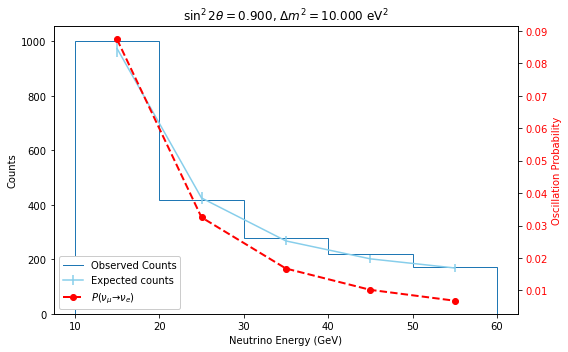

In [2]:
sin2_2theta = 0.9
delta_m2 = 10. # eV^2

counts, expected_signal = simulate_counts(
    sin2_2theta=sin2_2theta,
    delta_m2=delta_m2
)
plot_event_display(
    sin2_2theta=sin2_2theta,
    delta_m2=delta_m2,
    counts=counts,
    expected_signal=expected_signal,
)

## Traditional Feldman-Cousins

To determine the acceptance region of a point in the $\sin^2(2\theta) - \Delta m^2$ plane, we:

1. Use MC to simulate the results of a large number of experiments

2. Compute 
   $$
   \Delta \chi^2 = 2 \sum_i \left[ \mu_i - \mu_{\text{best}_i} + n_i \ln \left( \frac{\mu_{\text{best}_i} + b_i}{\mu_i + b_i} \right) \right],
   $$
   with $\mu_i$ the calculated expected oscillation contribution to the number of events, $b_i$ the known mean expected background, and $n_i$ the measured data in each of the bins. *Note: in this case, $b_i = 100$, $\mu_{\text{best}_i} = n_i - 100$. In more complicated experimental fits, $\mu_{\text{best}_i}$ can be computed via MLE or something similar.*

3. Within each grid point, compute a critical $\Delta \chi^2_c$ such that a fraction $\alpha$ of the $K$ simulated experiments have $\Delta \chi^2 < \Delta \chi^2_c$.

4. Compute $\Delta \chi^2$ for the observed experimental data $N = \{n_i\}$, and then admit a point into the acceptance region if

   $$
   \Delta \chi^2(N \mid \sin^2(2\theta), \Delta m^2) < \Delta \chi^2_c(\sin^2(2\theta), \Delta m^2).
   $$


In [177]:
# chi2 infrastructure
def compute_delta_chi2(x, sin2_2theta, delta_m2):
    out = 0.
    for i, E in enumerate(ENERGY_CENTERS):
        # getting mu_i, expected oscillation contributions
        P_avg = average_probability_over_L(sin2_2theta, delta_m2, E)
        mu_i = NORMALIZATION * P_avg
        
        # getting mu_best_i
        mu_best_i = x[i] - BACKGROUND_PER_BIN
        
        # update sum
        out += 2 * (mu_i - mu_best_i + x[i]*np.log((mu_best_i+BACKGROUND_PER_BIN)/(mu_i+BACKGROUND_PER_BIN)))
    return out

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 6375.06it/s]


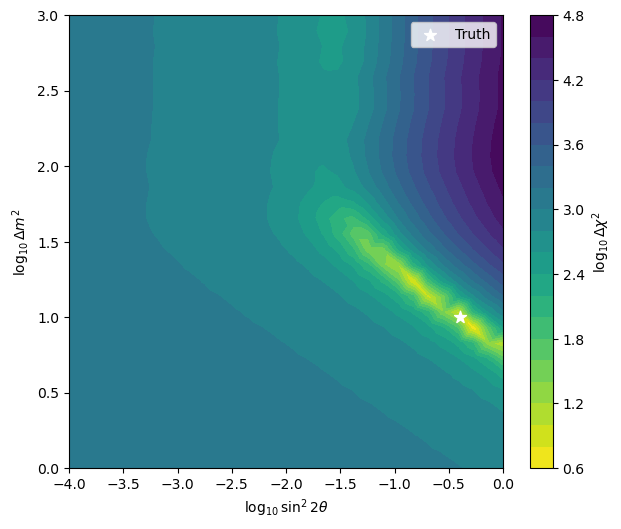

In [242]:
# example dchi2 distribution
sin2_2theta = 0.4
delta_m2 = 10. # eV^2
x, _ = simulate_counts(
    sin2_2theta=sin2_2theta,
    delta_m2=delta_m2
)

GRIDSIZE = 30
log_sin2_2theta_grid = np.linspace(*LOG_SIN2_2THETA_BOUNDS, GRIDSIZE)
log_delta_m2_grid = np.linspace(*LOG_DELTA_M2_BOUNDS, GRIDSIZE)
THETAS = np.array([[logsinsq, logdmsq] for logsinsq in log_sin2_2theta_grid for logdmsq in log_delta_m2_grid])

delta_chi2s = np.array([compute_delta_chi2(x, *(10**th)) for th in tqdm(THETAS)])

fig, ax = plt.subplots(1, 1, figsize=(7,6), dpi=100)
contour = ax.tricontourf(THETAS[:, 0], THETAS[:, 1], np.log10(delta_chi2s), levels=20, cmap='viridis_r')
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(r"$\log_{10} \Delta \chi^2 $")  # Set colorbar label
ax.scatter(np.log10(sin2_2theta), np.log10(delta_m2), color='white', label='Truth', marker='*', s=80)
ax.set_xlabel(r'$\log_{10} \sin^2 2 \theta$')
ax.set_ylabel(r'$\log_{10} \Delta m^2$')
plt.legend()
plt.show()

In [194]:
# computing critical dchi2 values. you only have to do this once!
ALPHA = 0.9
K = 1000
delta_chi2_crit_dict = {
    "sin2_2theta": [],
    "delta_m2": [],
    "delta_chi2_crit": [],
}

for log10_sin2_2theta, log10_delta_m2 in tqdm(THETAS):
    # simulate K experiments and compute dchi2s
    dchi2s_temp = []
    for _ in range(K):
        x_temp, _ = simulate_counts(
            sin2_2theta=10.**log10_sin2_2theta,
            delta_m2=10.**log10_delta_m2
        )
        dchi2_temp = compute_delta_chi2(
            x=x_temp,
            sin2_2theta=10.**log10_sin2_2theta,
            delta_m2=10.**log10_delta_m2,
        )
        dchi2s_temp.append(dchi2_temp)
        
    # compute alpha percentile and append
    delta_chi2_crit = np.quantile(dchi2s_temp, ALPHA)
    delta_chi2_crit_dict["sin2_2theta"].append(10.**log10_sin2_2theta)
    delta_chi2_crit_dict["delta_m2"].append(10.**log10_delta_m2)
    delta_chi2_crit_dict["delta_chi2_crit"].append(delta_chi2_crit)
    
delta_chi2_crit_df = pd.DataFrame(delta_chi2_crit_dict)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [03:45<00:00,  4.00it/s]


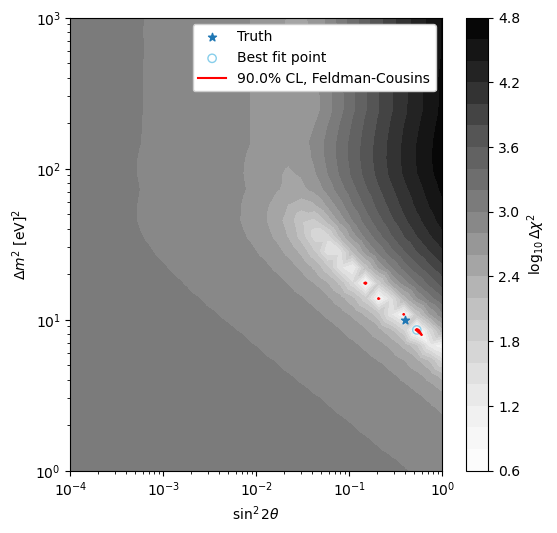

In [243]:
# feldman-cousins infrastructure
delta_chi2_df = pd.DataFrame({
    "sin2_2theta": 10.**THETAS[:, 0],
    "delta_m2": 10.**THETAS[:, 1],
    "delta_chi2": delta_chi2s,
})

acceptance_df = pd.merge(delta_chi2_df, delta_chi2_crit_df, on=['sin2_2theta', 'delta_m2'], how='inner')

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=100)
ax.tricontour(
    acceptance_df["sin2_2theta"],
    acceptance_df["delta_m2"],
    acceptance_df["delta_chi2"] - acceptance_df["delta_chi2_crit"],
    levels=[0.],
    colors='r'
)

contour = ax.tricontourf(
    acceptance_df["sin2_2theta"],
    acceptance_df["delta_m2"],
    np.log10(acceptance_df["delta_chi2"]),
    cmap='Greys',
    levels=20
)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(r"$\log_{10} \Delta \chi^2 $")  # Set colorbar label

sc1 = ax.scatter(sin2_2theta, delta_m2, marker='*', label='Truth')

bfp = tuple(acceptance_df[acceptance_df["delta_chi2"]==acceptance_df["delta_chi2"].min()][["sin2_2theta", "delta_m2"]].values.flatten())

sc2 = ax.scatter(*bfp, marker='o', facecolors='none', edgecolors='skyblue')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$\sin^2 2 \theta$")
ax.set_ylabel(r"$\Delta m^2$ [eV]$^2$")

# Proxy for tricontour line
from matplotlib.lines import Line2D
contour_proxy = Line2D([0], [0], color='red', linestyle='-')

# Combine legend handles and labels
handles = [sc1, sc2, contour_proxy]
labels = ["Truth", "Best fit point", f"{100*ALPHA}% CL, Feldman-Cousins"]

ax.legend(handles, labels, framealpha=1.)

plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 6598.71it/s]


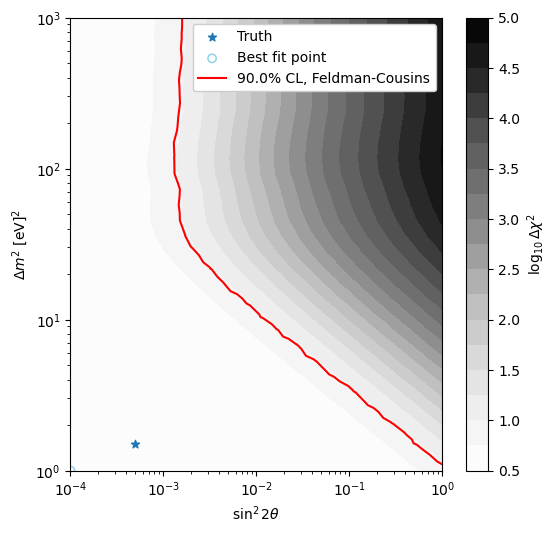

In [273]:
# another example, an exclusion
sin2_2theta_2 = 0.0005
delta_m2_2 = 1.5 # eV^2
x_2, _ = simulate_counts(
    sin2_2theta=sin2_2theta_2,
    delta_m2=delta_m2_2
)

delta_chi2s = np.array([compute_delta_chi2(x_2, *(10**th)) for th in tqdm(THETAS)])

delta_chi2_df = pd.DataFrame({
    "sin2_2theta": 10.**THETAS[:, 0],
    "delta_m2": 10.**THETAS[:, 1],
    "delta_chi2": delta_chi2s,
})

acceptance_fc_df = pd.merge(delta_chi2_df, delta_chi2_crit_df, on=['sin2_2theta', 'delta_m2'], how='inner')

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=100)
ax.tricontour(
    acceptance_fc_df["sin2_2theta"],
    acceptance_fc_df["delta_m2"],
    acceptance_fc_df["delta_chi2"] - acceptance_fc_df["delta_chi2_crit"],
    levels=[0.],
    colors='r'
)

contour = ax.tricontourf(
    acceptance_fc_df["sin2_2theta"],
    acceptance_fc_df["delta_m2"],
    np.log10(acceptance_fc_df["delta_chi2"]),
    cmap='Greys',
    levels=20
)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(r"$\log_{10} \Delta \chi^2 $")  # Set colorbar label

sc1 = ax.scatter(sin2_2theta_2, delta_m2_2, marker='*', label='Truth')

bfp = tuple(acceptance_fc_df[acceptance_fc_df["delta_chi2"]==acceptance_fc_df["delta_chi2"].min()][["sin2_2theta", "delta_m2"]].values.flatten())

sc2 = ax.scatter(*bfp, marker='o', facecolors='none', edgecolors='skyblue')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$\sin^2 2 \theta$")
ax.set_ylabel(r"$\Delta m^2$ [eV]$^2$")

# Proxy for tricontour line
from matplotlib.lines import Line2D
contour_proxy = Line2D([0], [0], color='red', linestyle='-')

# Combine legend handles and labels
handles = [sc1, sc2, contour_proxy]
labels = ["Truth", "Best fit point", f"{100*ALPHA}% CL, Feldman-Cousins"]

ax.legend(handles, labels, framealpha=1.)

plt.show()

## Implementation of Direct Amortized Neural Ratio Estimation

From <a href="https://arxiv.org/abs/2311.10571">2311.10571</a>.

### Data preparation

Let's define some priors. Namely, $\log \sin^2 2 \theta \sim \text{Unif} (-4, 0)$, $\log \Delta m^2 \, [\text{eV}^2] \sim \text{Unif} (0,3)$.

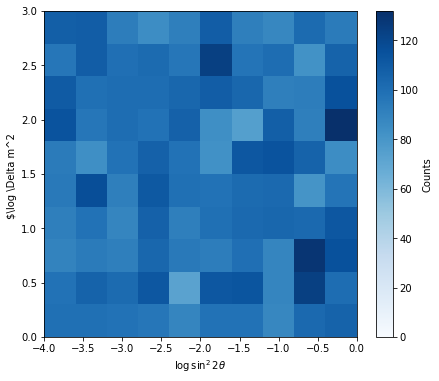

In [3]:
LOG_SIN2_2THETA_BOUNDS = (-4., 0.)
LOG_DELTA_M2_BOUNDS = (0., 3.)

def generate_from_uniform_prior(n_samples):
    log_sin2_2theta_samples = np.random.uniform(*LOG_SIN2_2THETA_BOUNDS, n_samples)
    log_delta_m2_samples = np.random.uniform(*LOG_DELTA_M2_BOUNDS, n_samples)
    return np.column_stack((log_sin2_2theta_samples, log_delta_m2_samples))

samples_to_plot = generate_from_uniform_prior(n_samples=10000)
fig, ax = plt.subplots(1, 1, figsize=(7,6), dpi=100)
h = ax.hist2d(samples_to_plot[:, 0], samples_to_plot[:, 1], vmin=0., cmap='Blues')
ax.set_xlim(*LOG_SIN2_2THETA_BOUNDS)
ax.set_ylim(*LOG_DELTA_M2_BOUNDS)
ax.set_xlabel(r'$\log \sin^2 2 \theta$')
ax.set_ylabel(r'$\log \Delta m^2 ')

plt.colorbar(h[3], ax=ax, label='Counts')
plt.show()

In [8]:
# calling on simulator
n_samples = 50000
thetas = generate_from_uniform_prior(n_samples)
theta_ps = generate_from_uniform_prior(n_samples)

xs = []
for theta in tqdm(thetas):
    xs.append(simulate_counts(*(10**theta))[0]) # recall theta is the log of the osc params
xs = np.array(xs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:06<00:00, 7789.49it/s]


In [12]:
# building labeled data
data1 = np.column_stack((xs, thetas, theta_ps, np.ones(n_samples)))
data0 = np.column_stack((xs, theta_ps, thetas, np.zeros(n_samples)))

data = np.row_stack((data1, data0))

In [17]:
# building training and test-set data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = data[:, :-1]; y = data[:, -1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

### Network training

Build any classifier that you want. I just want something a bit straightforward and easy to run.

In [19]:
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras import layers

inputs = Input(shape=(X_train.shape[1],))
x = inputs

for _ in range(5):
    x = layers.Dense(64, activation='relu')(x)

pre_sigmoid = layers.Dense(1)(x)
outputs = layers.Activation('sigmoid')(pre_sigmoid)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/200
2344/2344 [==============================] - 1s 542us/step - loss: 0.4014 - accuracy: 0.7641 - val_loss: 0.3539 - val_accuracy: 0.7930
Epoch 2/200
2344/2344 [==============================] - 1s 510us/step - loss: 0.2853 - accuracy: 0.8330 - val_loss: 0.2868 - val_accuracy: 0.8307
Epoch 3/200
2344/2344 [==============================] - 1s 509us/step - loss: 0.2560 - accuracy: 0.8510 - val_loss: 0.3232 - val_accuracy: 0.8162
Epoch 4/200
2344/2344 [==============================] - 1s 511us/step - loss: 0.2444 - accuracy: 0.8562 - val_loss: 0.2513 - val_accuracy: 0.8485
Epoch 5/200
2344/2344 [==============================] - 1s 512us/step - loss: 0.2423 - accuracy: 0.8557 - val_loss: 0.2276 - val_accuracy: 0.8657
Epoch 6/200
2344/2344 [==============================] - 1s 512us/step - loss: 0.2370 - accuracy: 0.8603 - val_loss: 0.2292 - val_accuracy: 0.8669
Epoch 7/200
2344/2344 [==============================] - 1s 509us/step - loss: 0.2346 - accuracy: 0.8605 - val_loss: 0

2344/2344 [==============================] - 1s 527us/step - loss: 0.2030 - accuracy: 0.8820 - val_loss: 0.2050 - val_accuracy: 0.8801
Epoch 57/200
2344/2344 [==============================] - 1s 524us/step - loss: 0.2027 - accuracy: 0.8807 - val_loss: 0.2092 - val_accuracy: 0.8746
Epoch 58/200
2344/2344 [==============================] - 1s 528us/step - loss: 0.2031 - accuracy: 0.8816 - val_loss: 0.2047 - val_accuracy: 0.8786
Epoch 59/200
2344/2344 [==============================] - 1s 533us/step - loss: 0.2022 - accuracy: 0.8814 - val_loss: 0.2025 - val_accuracy: 0.8794
Epoch 60/200
2344/2344 [==============================] - 1s 554us/step - loss: 0.2020 - accuracy: 0.8822 - val_loss: 0.2077 - val_accuracy: 0.8762
Epoch 61/200
2344/2344 [==============================] - 1s 523us/step - loss: 0.2014 - accuracy: 0.8821 - val_loss: 0.2027 - val_accuracy: 0.8766
Epoch 62/200
2344/2344 [==============================] - 1s 531us/step - loss: 0.2024 - accuracy: 0.8813 - val_loss: 0.2011 

In [21]:
# Create a model that ends at the pre-sigmoid layer (useful later)
pre_sigmoid_model = Model(inputs=model.input, outputs=pre_sigmoid)

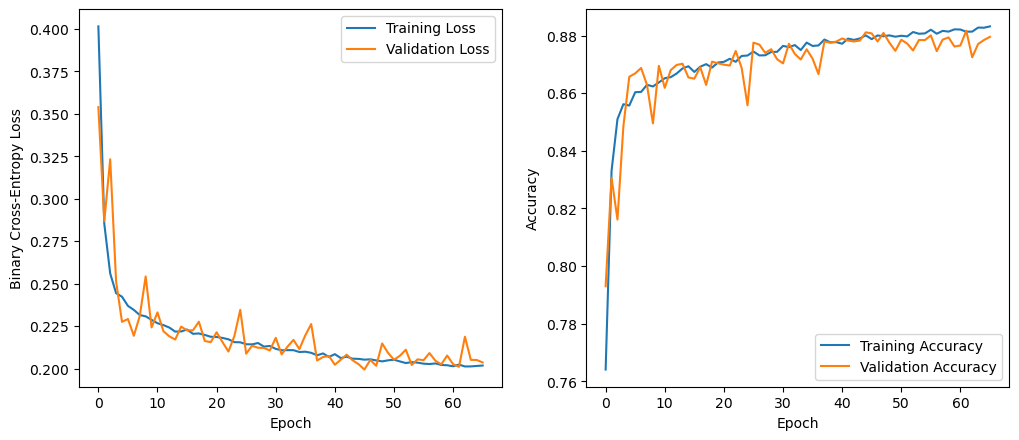

In [94]:
# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Binary Cross-Entropy Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

782/782 [==============================] - 0s 215us/step


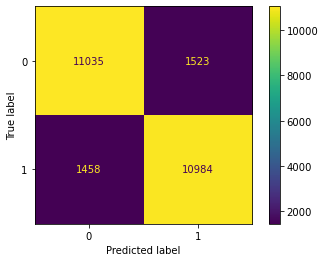

In [27]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_preds = model.predict(X_test).flatten() > 0.5
cm = confusion_matrix(y_test, y_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Uses of the Network: Likelihood Ratio and Posterior Density Estimation

**Likelihood ratio estimation.** From <a href="https://arxiv.org/abs/2311.10571">the paper</a>, if $d$ is our neural network, we have that:

$$ \frac{P (x | \theta)}{P (x | \theta')} = \frac{d (x, \theta, \theta')}{1 - d (x, \theta, \theta') } $$

The final activation layer is a sigmoid function:

$$ \sigma (x) = \frac{1}{1 + e^{-x}}$$

Let $d_{\phi - \sigma}$ be the subnetwork consisting of all layers except the final activation. That is, $d (x, \theta, \theta') = \sigma (d_{\phi - \sigma} (x, \theta, \theta'))$. Then:

$$ \frac{P (x | \theta)}{P (x | \theta')} = \frac{d (x, \theta, \theta')}{1 - d (x, \theta, \theta') } = \frac{\sigma (d_{\phi - \sigma} (x, \theta, \theta') )}{1 - \sigma (d_{\phi - \sigma} (x, \theta, \theta') )} = \frac{\frac{1}{1 + \exp (- d_{\phi - \sigma} (x, \theta, \theta')) }}{1 - \frac{1}{1 + \exp (- d_{\phi - \sigma} (x, \theta, \theta')) }} = \frac{1}{1 + \exp (- d_{\phi - \sigma} (x, \theta, \theta')) - 1} = \exp (  d_{\phi - \sigma} (x, \theta, \theta'))$$

And of course, conveniently:

$$ \Delta LLH = \log P (x | \theta) - \log P (x | \theta') = d_{\phi - \sigma} (x, \theta, \theta'). $$

**Posterior density estimation.** We cite Eq. 7:

$$ \log⁡ p(\theta | x) = \log p (\theta) + \log M - \log \sum_{i=1}^M \exp [ - \log r(x, \theta, \theta_i') ]$$

Then:

$$ \log p(\theta | x) = \log p (\theta) + \log M - \log \sum_{i=1}^M \exp [ - \log \exp d_{\phi - \sigma} (x , \theta, \theta') ] = \log p (\theta) + \log M - \log \sum_{i=1}^M \exp [ - d_{\phi - \sigma} (x, \theta, \theta') ]. $$

For numerical stability, consider $a_i$ and $\overline{a} = \max_i a_i$ such that:

$$ \log \sum_i \exp a_i = \log \sum_i \exp (\overline{a} - \overline{a} + a_i)  =  \log \sum_i \exp ( \overline{a}) \exp (- \overline{a} + a_i) = \log \bigg{[} \exp (\overline{a}) \sum_i \exp (-\overline{a} + a_i ) \bigg{]} = \overline{a} + \log \sum_i \exp (- \overline{a} + a_i)$$

To build the approximate test statistic for a Feldman-Cousins stepthrough, I will use the maximum _a posteriori_ as the best fit point estimate for an experimental realization and use this grid point for the denominator of the likelihood ratio estimate.

In [150]:
def _fill_neg_inf_with_min(arr):
    """Fills negative infinities in a NumPy array with its smallest value.

    Args:
        arr (np.ndarray): The input NumPy array.

    Returns:
        np.ndarray: A new array with negative infinities replaced.
    """
    arr = np.array(arr, dtype=float)
    b = np.sort(arr)
    min_val = b[~np.isneginf(b)][1]
    arr[np.isneginf(arr)] = min_val
    return arr


def _make_network_input(inpx, inpth, inpthp, scaler):
    inp = np.hstack((inpx, inpth, inpthp))
    inp_scaled = scaler.transform(inp)
    return inp_scaled   


def compute_log_posterior(thetas, x, M, pre_sigmoid_model, scaler):
    """
    thetas : np.ndarray
        List of grid points in model parameter space on which to evaluate posterior density
    x : array-like
        Raw experimental realization
    M : int
        Number of samples to use in MC mean
    pre_sigmoid_model
        Trained subnetwork consisting of all layers except final activation
    scaler
        MinMaxScaler used for input data preparation
    """
    N = thetas.shape[0]
    
    # using flat prior
    log_prior = np.log(1 / (
        (LOG_SIN2_2THETA_BOUNDS[1] - LOG_SIN2_2THETA_BOUNDS[0]) * \
        (LOG_DELTA_M2_BOUNDS[1] - LOG_DELTA_M2_BOUNDS[0])
    ))
    log_M = np.log(M)
    
    # sample prior M times, shared across all thetas
    theta_ps = generate_from_uniform_prior(M)  # shape: (M, prior_dim)

    # prepare nn inputs
    inpx = np.repeat(np.array([x]), N * M, axis=0)  # shape: (N*M, x_dim)
    inpth = np.repeat(thetas, M, axis=0)            # shape: (N*M, 2)
    theta_ps_tiled = np.tile(theta_ps, (N, 1))      # shape: (N*M, prior_dim)

    inp_scaled = _make_network_input(inpx, inpth, theta_ps_tiled, scaler) # shape: (N*M, total_input_dim)

    # predict
    pre_sigmoid_preds = pre_sigmoid_model.predict_on_batch(inp_scaled)  # shape: (N*M, 1) or (N*M,)
    pre_sigmoid_preds = pre_sigmoid_preds.reshape(N, M)

    # logpost
    log_posteriors = log_prior + log_M - np.log(np.exp(-pre_sigmoid_preds).sum(axis=1))
    
    return _fill_neg_inf_with_min(np.array(log_posteriors))

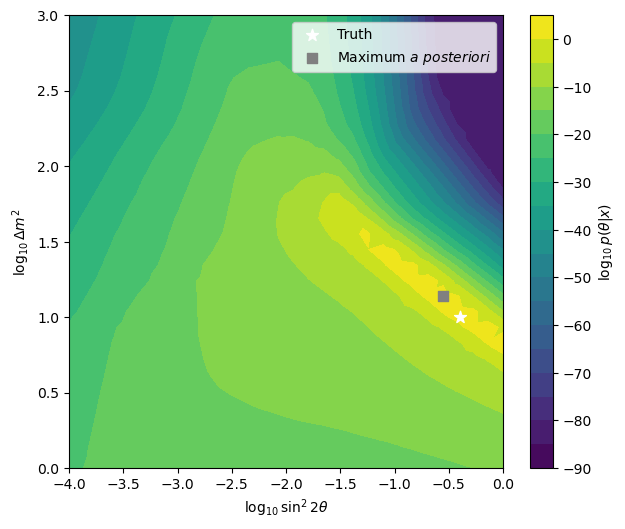

In [151]:
# example computation of posterior
M = 200
log_posterior = compute_log_posterior(THETAS, x, M, pre_sigmoid_model, scaler)

bfp = THETAS[np.argmax(log_posterior)]

fig, ax = plt.subplots(1, 1, figsize=(7,6), dpi=100)
contour = ax.tricontourf(THETAS[:, 0], THETAS[:, 1], _fill_neg_inf_with_min(log_posterior), levels=20)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(r"$ \log_{10} p(\theta | x) $")  # Set colorbar label
ax.scatter(np.log10(sin2_2theta), np.log10(delta_m2), color='white', label='Truth', marker='*', s=80)
ax.scatter(*bfp, color='gray', marker='s', s=60, label=r'Maximum $\it{a\,\,posteriori}$')
ax.set_xlabel(r'$\log_{10} \sin^2 2 \theta$')
ax.set_ylabel(r'$\log_{10} \Delta m^2$')
plt.legend()
plt.show()

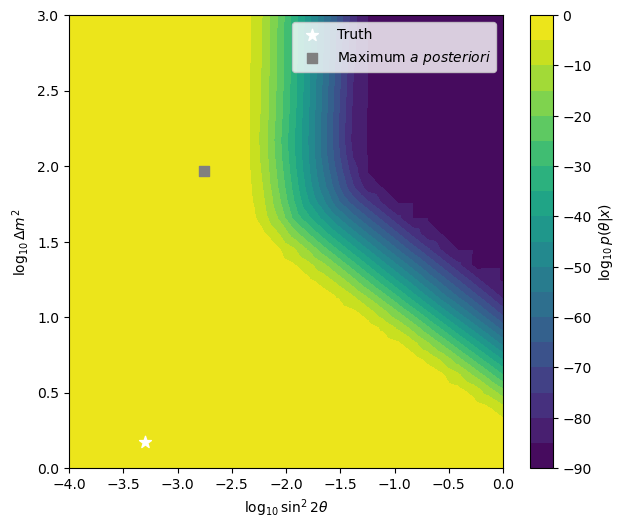

In [247]:
# example computation of posterior
M = 200
log_posterior_2 = compute_log_posterior(THETAS, x_2, M, pre_sigmoid_model, scaler)

bfp_2 = THETAS[np.argmax(log_posterior_2)]

fig, ax = plt.subplots(1, 1, figsize=(7,6), dpi=100)
contour = ax.tricontourf(THETAS[:, 0], THETAS[:, 1], _fill_neg_inf_with_min(log_posterior_2), levels=20)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(r"$ \log_{10} p(\theta | x) $")  # Set colorbar label
ax.scatter(np.log10(sin2_2theta_2), np.log10(delta_m2_2), color='white', label='Truth', marker='*', s=80)
ax.scatter(*bfp_2, color='gray', marker='s', s=60, label=r'Maximum $\it{a\,\,posteriori}$')
ax.set_xlabel(r'$\log_{10} \sin^2 2 \theta$')
ax.set_ylabel(r'$\log_{10} \Delta m^2$')
plt.legend()
plt.show()

In [152]:
def compute_dllh_estimate(theta, x, pre_sigmoid_model, scaler, M, posterior_gridsize):
    """
    Estimate of dLLH between gridpoint theta and best fit point (MAP) for experimental realization x
    
    theta : array-like
        Grid-point at which to compute test statistic
    x : array-like
        Raw experimental realization
    pre_sigmoid_model
        Trained subnetwork consisting of all layers except final activation
    scaler
        MinMaxScaler used for input data preparation
    M : int
        Number of samples to use in MC mean
    posterior_gridsize : int
        Gridsize to use for posterior computation (and thus granularity of MAP bfp estimate)
    """
    # getting the MAP
    log_sin2_2theta_grid = np.linspace(*LOG_SIN2_2THETA_BOUNDS, posterior_gridsize)
    log_delta_m2_grid = np.linspace(*LOG_DELTA_M2_BOUNDS, posterior_gridsize)
    thetas_for_posterior = np.array(
        [[logsinsq, logdmsq] for logsinsq in log_sin2_2theta_grid for logdmsq in log_delta_m2_grid]
    )
    log_posterior = compute_log_posterior(thetas_for_posterior, x, M, pre_sigmoid_model, scaler)
    bfp = thetas_for_posterior[np.argmax(log_posterior)]
    
    # computing likelihood ratio estimate
    inp_scaled = _make_network_input(x.reshape(1, -1), theta.reshape(1, -1), bfp.reshape(1, -1), scaler)
    return pre_sigmoid_model.predict(inp_scaled, verbose=0).flatten()[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:46<00:00, 19.34it/s]


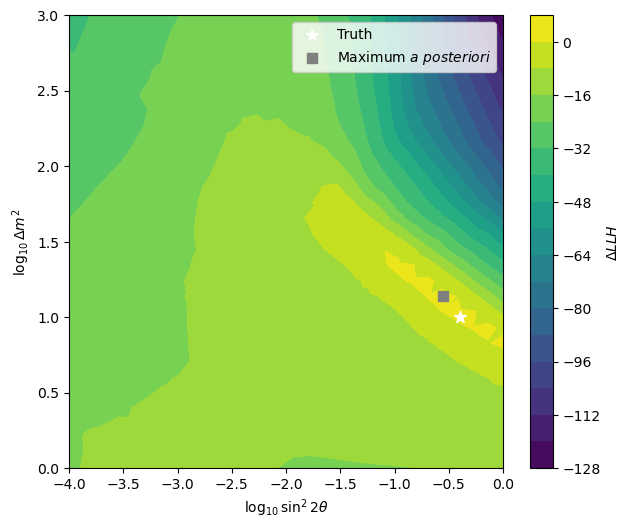

In [156]:
# computing the dLLH on the grid for an example
import warnings
warnings.filterwarnings('ignore')
dllhs = [compute_dllh_estimate(th, x, pre_sigmoid_model, scaler, M, GRIDSIZE) for th in tqdm(THETAS)]

fig, ax = plt.subplots(1, 1, figsize=(7,6), dpi=100)
contour = ax.tricontourf(THETAS[:, 0], THETAS[:, 1], dllhs, levels=20)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(r"$ \Delta LLH $")  # Set colorbar label
ax.scatter(np.log10(sin2_2theta), np.log10(delta_m2), color='white', label='Truth', marker='*', s=80)
ax.scatter(*bfp, color='gray', marker='s', s=60, label=r'Maximum $\it{a\,\,posteriori}$')
ax.set_xlabel(r'$\log_{10} \sin^2 2 \theta$')
ax.set_ylabel(r'$\log_{10} \Delta m^2$')
plt.legend()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:45<00:00, 19.87it/s]


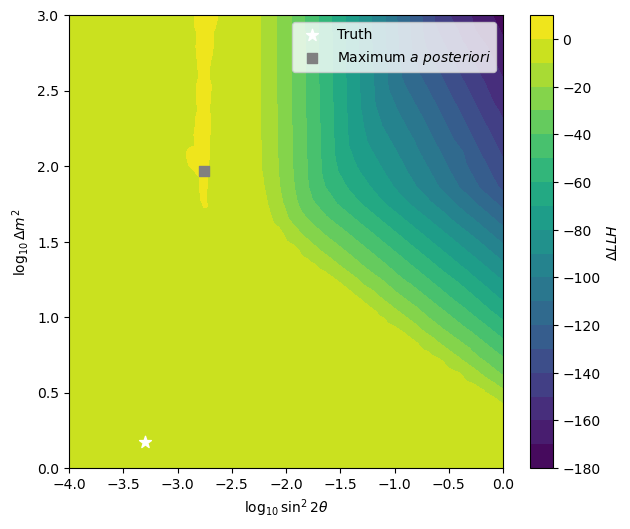

In [248]:
dllhs_2 = [compute_dllh_estimate(th, x_2, pre_sigmoid_model, scaler, M, GRIDSIZE) for th in tqdm(THETAS)]

fig, ax = plt.subplots(1, 1, figsize=(7,6), dpi=100)
contour = ax.tricontourf(THETAS[:, 0], THETAS[:, 1], dllhs_2, levels=20)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(r"$ \Delta LLH $")  # Set colorbar label
ax.scatter(np.log10(sin2_2theta_2), np.log10(delta_m2_2), color='white', label='Truth', marker='*', s=80)
ax.scatter(*bfp_2, color='gray', marker='s', s=60, label=r'Maximum $\it{a\,\,posteriori}$')
ax.set_xlabel(r'$\log_{10} \sin^2 2 \theta$')
ax.set_ylabel(r'$\log_{10} \Delta m^2$')
plt.legend()
plt.show()

## Building Confidence Level Estimates

The procedure is pretty much the same as Feldman-Cousins; the only difference is that $\Delta \chi^2$ is not computed exactly; an estimate of $\Delta LLH$ comes from the trained neural network.

In [255]:
# computing critical dchi2 values. you only have to do this once!
ALPHA = 0.9
K = 10
dllh_estimate_crit_dict = {
    "sin2_2theta": [],
    "delta_m2": [],
    "dllh_estimate_crit": [],
}

for th in tqdm(THETAS):
    # simulate K experiments and compute dchi2s
    dllh_estimates_temp = []
    for _ in range(K):
        x_temp, _ = simulate_counts(
            sin2_2theta=10.**log10_sin2_2theta,
            delta_m2=10.**log10_delta_m2
        )
        
        dllh_estimate_temp = compute_dllh_estimate(
            theta=th,
            x=x_temp,
            pre_sigmoid_model=pre_sigmoid_model,
            scaler=scaler,
            M=M,
            posterior_gridsize=GRIDSIZE
        )
        dllh_estimates_temp.append(dllh_estimate_temp)
        
    # compute alpha percentile and append
    dllh_estimate_crit = np.quantile(-2*dllh_estimate_temp, ALPHA) # this sign matters!
    dllh_estimate_crit_dict["sin2_2theta"].append(10.**th[0])
    dllh_estimate_crit_dict["delta_m2"].append(10.**th[1])
    dllh_estimate_crit_dict["-2dllh_estimate_crit"].append(dllh_estimate_crit)
    
dllh_estimate_crit_df = pd.DataFrame(dllh_estimate_crit_dict)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [08:05<00:00,  1.85it/s]


In [274]:
# another example, an exclusion
neg_2llh_estimates = np.array([
    -2*compute_dllh_estimate(
        theta=th,
        x=x_2,
        pre_sigmoid_model=pre_sigmoid_model,
        scaler=scaler,
        M=M,
        posterior_gridsize=GRIDSIZE
    )
    for th in tqdm(THETAS)
])

neg_2llh_df = pd.DataFrame({
    "sin2_2theta": 10.**THETAS[:, 0],
    "delta_m2": 10.**THETAS[:, 1],
    "-2dllh_estimate": neg_2llh_estimates,
})

acceptance_df = pd.merge(neg_2llh_df, dllh_estimate_crit_df, on=['sin2_2theta', 'delta_m2'], how='inner')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:49<00:00, 18.03it/s]


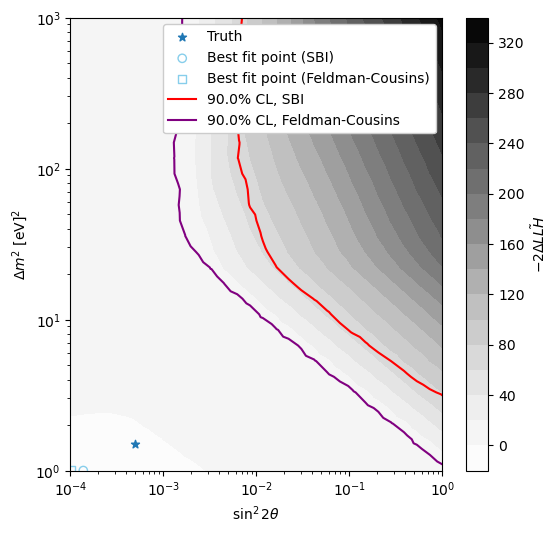

In [278]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=100)

# SBI
ax.tricontour(
    acceptance_df["sin2_2theta"],
    acceptance_df["delta_m2"],
    acceptance_df["-2dllh_estimate"] - acceptance_df["dllh_estimate_crit"],
    levels=[0.],
    colors='r'
)

# Feldman-Cousins
ax.tricontour(
    acceptance_fc_df["sin2_2theta"],
    acceptance_fc_df["delta_m2"],
    acceptance_fc_df["delta_chi2"] - acceptance_fc_df["delta_chi2_crit"],
    levels=[0.],
    colors='purple',
)


contour = ax.tricontourf(
    acceptance_df["sin2_2theta"],
    acceptance_df["delta_m2"],
    acceptance_df["-2dllh_estimate"],
    cmap='Greys',
    levels=20
)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(r"$-2 \Delta \tilde{LLH} $")  # Set colorbar label

sc1 = ax.scatter(sin2_2theta_2, delta_m2_2, marker='*', label='Truth')

bfp = tuple(acceptance_df[acceptance_df["-2dllh_estimate"]==acceptance_df["-2dllh_estimate"].min()][["sin2_2theta", "delta_m2"]].values.flatten())

sc2 = ax.scatter(*bfp, marker='o', facecolors='none', edgecolors='skyblue')

bfp_fc = tuple(acceptance_fc_df[acceptance_fc_df["delta_chi2"]==acceptance_fc_df["delta_chi2"].min()][["sin2_2theta", "delta_m2"]].values.flatten())

sc3 = ax.scatter(*bfp_fc, marker='s', facecolors='none', edgecolors='skyblue')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$\sin^2 2 \theta$")
ax.set_ylabel(r"$\Delta m^2$ [eV]$^2$")

contour_proxy = Line2D([0], [0], color='red', linestyle='-')
contour_proxy_fc = Line2D([0], [0], color='purple', linestyle='-')

# Combine legend handles and labels
handles = [sc1, sc2, sc3, contour_proxy, contour_proxy_fc]
labels = ["Truth", "Best fit point (SBI)", "Best fit point (Feldman-Cousins)", f"{100*ALPHA}% CL, SBI", f"{100*ALPHA}% CL, Feldman-Cousins"]

ax.legend(handles, labels, framealpha=1.)

plt.show()